# CS5100 Group Project

In [8]:
# Import libraries
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,15
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [9]:
#Read the dataset
df=pd.read_csv("NSE-TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


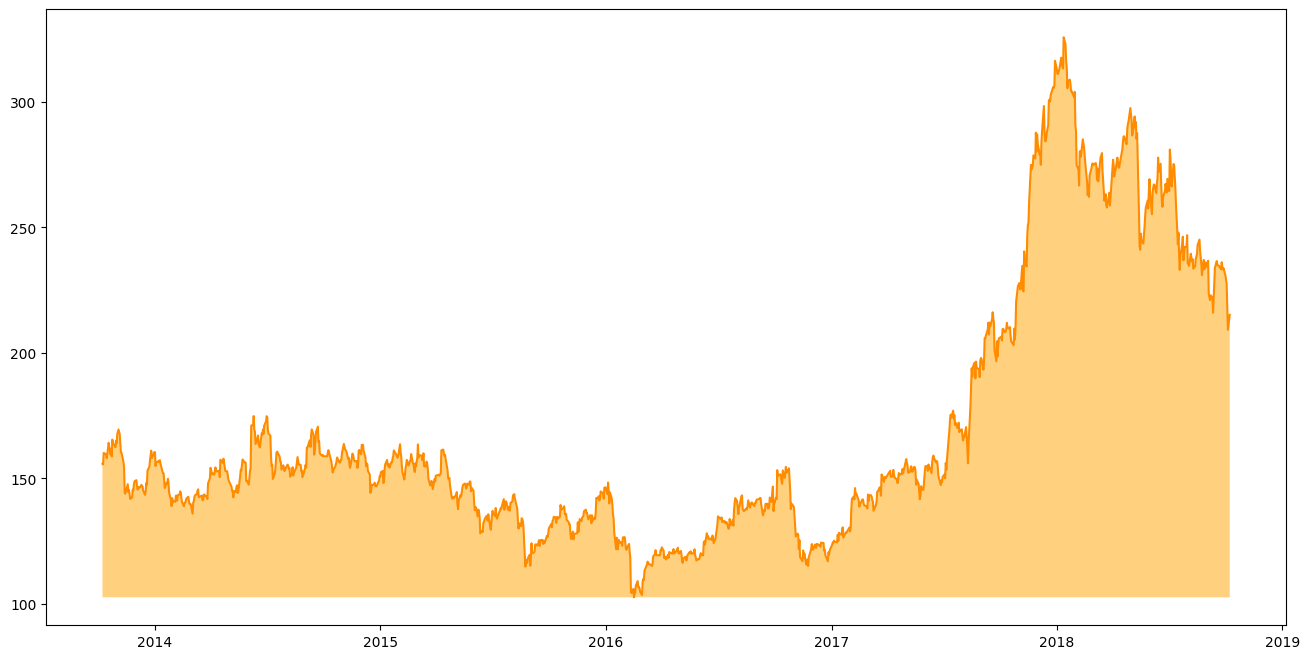

In [10]:
#Analyze the closing prices from dataframe
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
Closemin = df.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history', color='darkorange')
plt.fill_between(df.index, Closemin, df.Close, facecolor='orange', alpha = 0.5)

In [11]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [12]:
#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [13]:
#Build and train the LSTM model:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

Metal device set to: Apple M1 Pro


2022-11-17 01:02:39.650836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 01:02:39.651054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-17 01:02:40.765755: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 01:02:41.949507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-17 01:02:42.093865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-17 01:02:43.462487: I tensorflow/core/grappler/o

927/927 - 30s - loss: 0.0011 - 30s/epoch - 32ms/step


In [14]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

2022-11-17 01:03:10.978707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-17 01:03:11.038150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/8 [==>...........................] - ETA: 13s

2022-11-17 01:03:12.166312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 2s 36ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_38542/3108069254.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


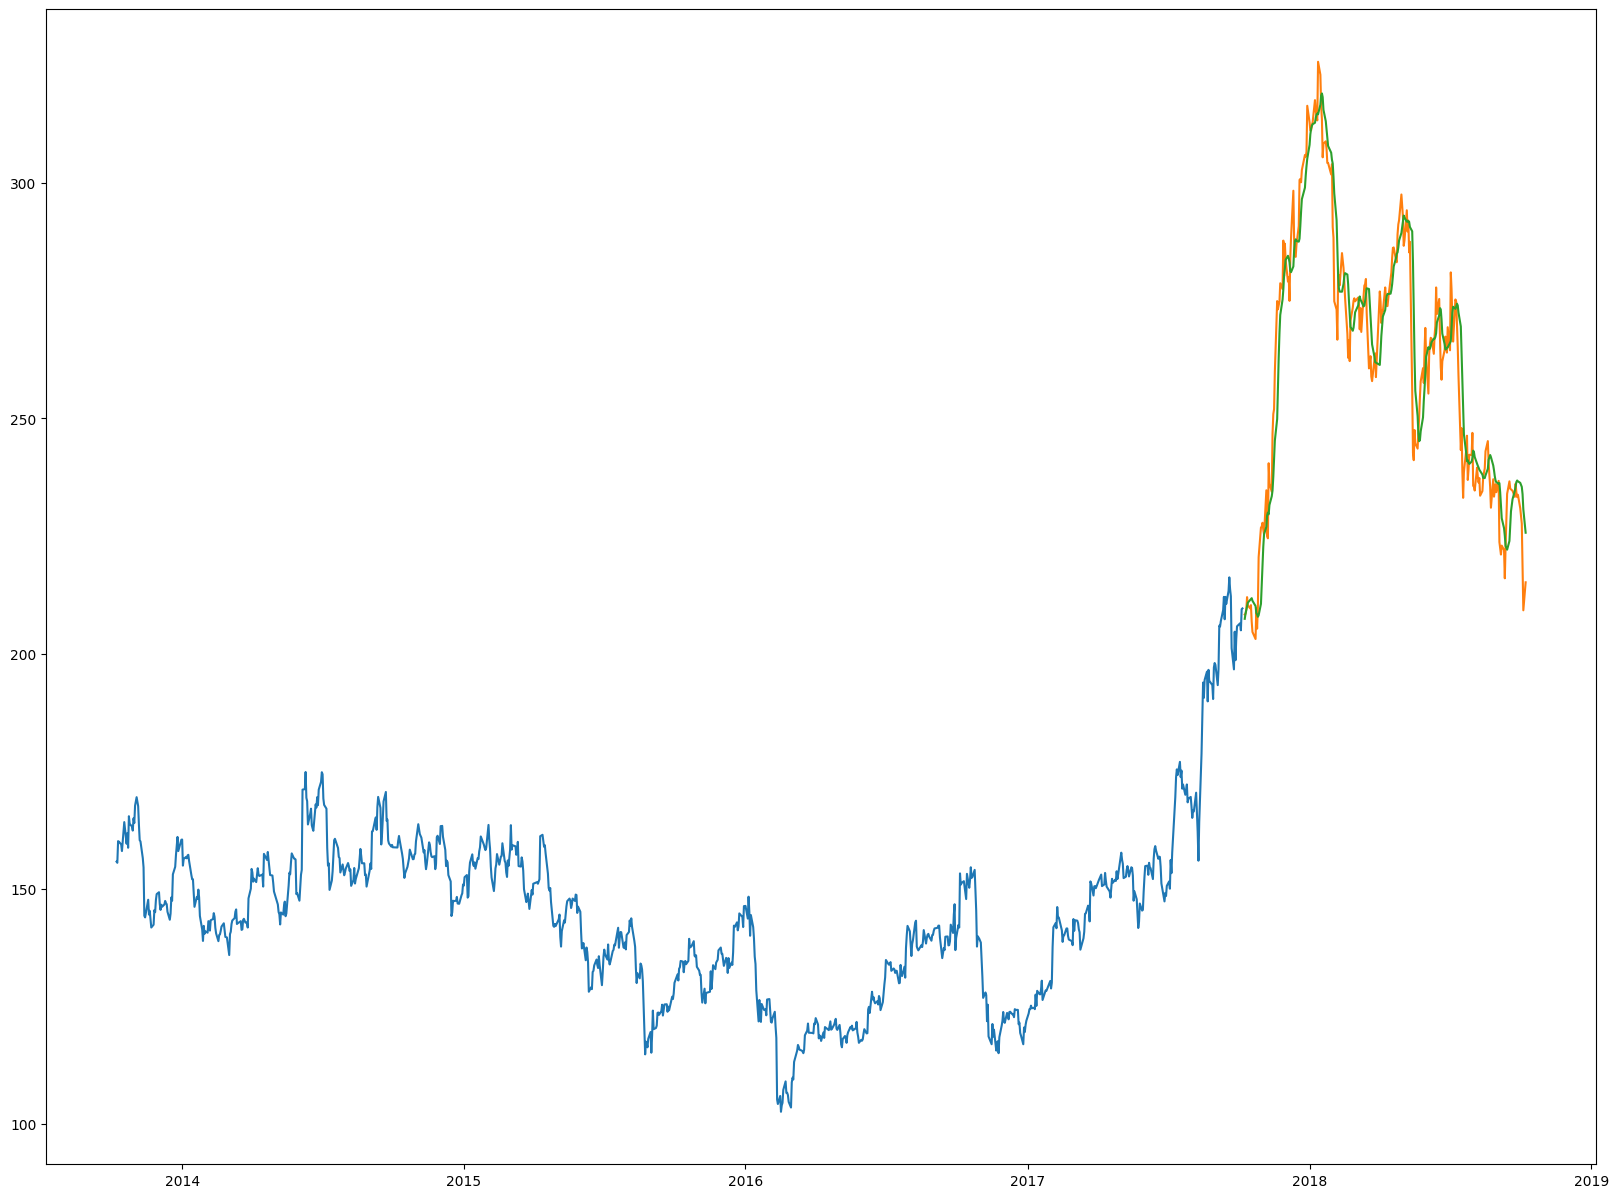

In [15]:
#Save the LSTM model
lstm_model.save("saved_model.h5")

#Visualize the predicted stock costs with actual stock costs
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [ ]:
!python3 stock_app.py

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

2022-11-17 01:19:11.631462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 01:19:11.631594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-17 01:19:12.186046: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 01:19:12.494261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-17 01:19:12.554786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for dev